In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Imports
import pandas as pd
import numpy as np
import os
import glob
import random
from scipy.fft import fft
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 2. Shuffle and split subjects randomly
file_paths = glob.glob(os.path.join(r'C:\Users\Jay\Desktop\ML\har70\har70plus', '*'))

random.seed(42)  # for reproducibility
random.shuffle(file_paths)

# 80% train, 20% test
split_idx = int(0.7 * len(file_paths))
train_file_paths = file_paths[:split_idx]
test_file_paths = file_paths[split_idx:]

print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# 3. Fourier-only feature extraction function
def extract_fft_features(window_df, sampling_rate=50):
    features = {}
    
    sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
    window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
    window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
    for col in sensor_cols + ['back_mag', 'thigh_mag']:
        arr = window_df[col].to_numpy()
        fft_vals = np.abs(fft(arr))
        n = len(arr)
        
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
        dom_idx = np.argmax(fft_vals[1:]) + 1
        dom_freq = abs(freqs[dom_idx])
        
        spectral_energy = np.sum(fft_vals**2)
        
        features[f'{col}_dom_freq_hz'] = dom_freq
        features[f'{col}_spectral_energy'] = spectral_energy
    
    return features


# 4. Process a subject file
def process_subject_fft(file_path, window_size_seconds=5, sampling_rate=50):
    df = pd.read_csv(file_path)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    features_list = []
    labels_list = []
    
    start_idx = 0
    total_samples = df.shape[0]
    
    while start_idx < total_samples:
        start_time = df.iloc[start_idx]['timestamp']
        end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        
        window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
        
        if len(window_df) < 10:
            start_idx += 1
            continue
        
        features = extract_fft_features(window_df, sampling_rate)
        # features = extract_fft_stat_features(window_df, sampling_rate)
        majority_label = Counter(window_df['label']).most_common(1)[0][0]
        
        features_list.append(features)
        labels_list.append(majority_label)
        
        start_idx = window_df.index[-1] + 1
        
    return pd.DataFrame(features_list), labels_list


# def extract_fft_stat_features(window_df, sampling_rate=50):
#     features = {}
    
#     sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
#     # Magnitude columns
#     window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
#     window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
#     for col in sensor_cols + ['back_mag', 'thigh_mag']:
#         arr = window_df[col].to_numpy()
#         fft_vals = np.abs(fft(arr))
#         n = len(arr)
        
#         freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
#         dom_idx = np.argmax(fft_vals[1:]) + 1
#         dom_freq = abs(freqs[dom_idx])
        
#         spectral_energy = np.sum(fft_vals**2)
        
#         # --- Add FFT Features ---
#         features[f'{col}_dom_freq_hz'] = dom_freq
#         features[f'{col}_spectral_energy'] = spectral_energy
        
#         # --- Add Statistical Features ---
#         features[f'{col}_mean'] = np.mean(arr)
#         features[f'{col}_median'] = np.median(arr)
#         features[f'{col}_std'] = np.std(arr)
#         features[f'{col}_mode'] = mode(arr, keepdims=False)[0]  # Using scipy's mode
        
#     return features


# 5. Process all files
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for file in train_file_paths:
    features_df, labels = process_subject_fft(file)
    X_train_list.append(features_df)
    y_train_list.extend(labels)

for file in test_file_paths:
    features_df, labels = process_subject_fft(file)
    X_test_list.append(features_df)
    y_test_list.extend(labels)

# 6. Final datasets
X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
y_train = np.array(y_train_list)

X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
y_test = np.array(y_test_list)

print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)


Training subjects: 12, Testing subjects: 6
Final X_train shape: (5951, 16)
Final X_test shape: (3184, 16)



Starting Random Forest Grid Search...

Fitting 3 folds for each of 540 candidates, totalling 1620 fits

✅ Best Random Forest Parameters:
{'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
✅ Best Random Forest Cross-Validation Score: 0.9173

Starting Gradient Boosting Grid Search...

Fitting 3 folds for each of 256 candidates, totalling 768 fits

✅ Best Gradient Boosting Parameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
✅ Best Gradient Boosting Cross-Validation Score: 0.9262

--- Evaluating Best Random Forest ---
Random Forest Test Accuracy: 0.9130025125628141

Classification Report (Random Forest):
               precision    recall  f1-score   support

           1       0.91      0.99      0.95      1438
           3       0.50      0.02      0.04        51
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.97  

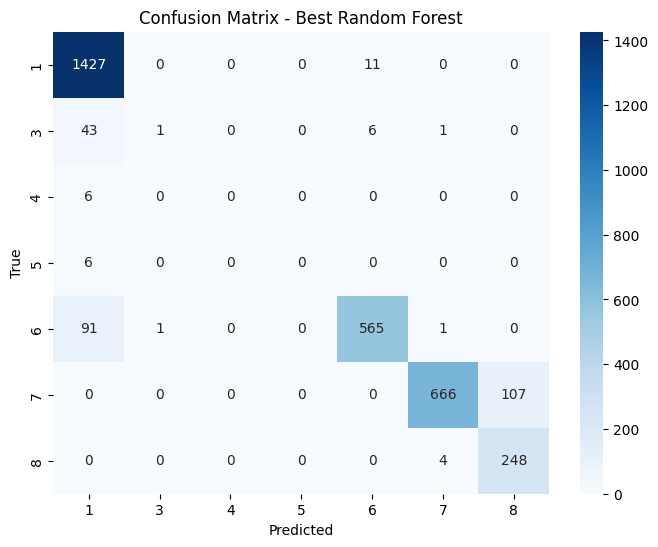


--- Evaluating Best Gradient Boosting ---
Gradient Boosting Test Accuracy: 0.9152010050251256

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           1       0.91      0.99      0.95      1438
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.96      0.87      0.91       658
           7       0.99      0.86      0.92       773
           8       0.70      0.99      0.82       252

    accuracy                           0.92      3184
   macro avg       0.51      0.53      0.52      3184
weighted avg       0.91      0.92      0.91      3184



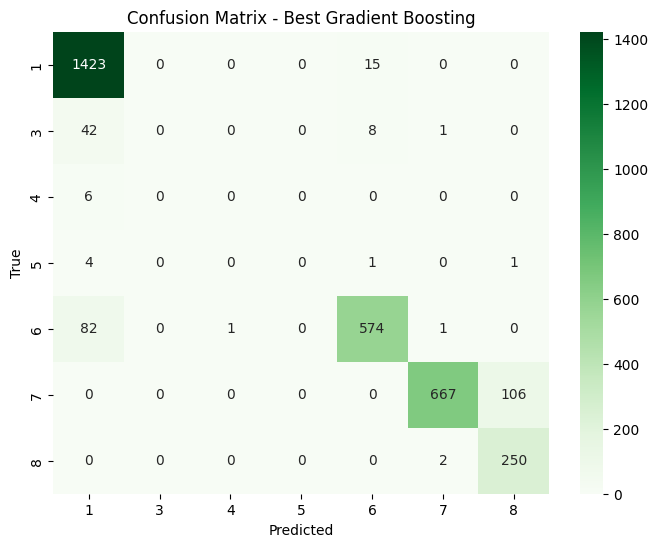

In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# 2. Assume you already have these
# X_train, X_test, y_train, y_test (7-class labels)

# 3. Define exhaustive hyperparameter grids

# Random Forest Grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Gradient Boosting Grid
gb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# 4. Random Forest Grid Search
print("\nStarting Random Forest Grid Search...\n")
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3,
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

print("\n✅ Best Random Forest Parameters:")
print(rf_grid_search.best_params_)
print(f"✅ Best Random Forest Cross-Validation Score: {rf_grid_search.best_score_:.4f}")

# Save best RF model
best_rf_model = rf_grid_search.best_estimator_

# 5. Gradient Boosting Grid Search
print("\nStarting Gradient Boosting Grid Search...\n")
gb = GradientBoostingClassifier(random_state=42)

gb_grid_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3,
    n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)

print("\n✅ Best Gradient Boosting Parameters:")
print(gb_grid_search.best_params_)
print(f"✅ Best Gradient Boosting Cross-Validation Score: {gb_grid_search.best_score_:.4f}")

# Save best GB model
best_gb_model = gb_grid_search.best_estimator_

# 6. Retrain Best Models on Full Training Set and Evaluate

# Evaluate Best Random Forest
print("\n--- Evaluating Best Random Forest ---")
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Best Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate Best Gradient Boosting
print("\n--- Evaluating Best Gradient Boosting ---")
y_pred_gb = best_gb_model.predict(X_test)

print("Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))

cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Best Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [4]:
# 1. Imports
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

# 2. Expanded Parameter Grids

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', 0.6, 0.8, None],
    'criterion': ['gini', 'entropy']
}

# Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
    'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.6, 0.8, None]
}

# 3. Random Forest Randomized SearchCV
print("\nStarting Randomized Search for Random Forest...\n")

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=1000,                # Try 500 random settings
    scoring='accuracy',
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

print("\n✅ Best Random Forest Parameters (Randomized Search):")
print(rf_random_search.best_params_)
print("✅ Best Random Forest Cross-Validation Score:", rf_random_search.best_score_)

best_rf_model = rf_random_search.best_estimator_

# 4. Gradient Boosting Randomized SearchCV
print("\nStarting Randomized Search for Gradient Boosting...\n")

gb = GradientBoostingClassifier(random_state=42)

gb_random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_grid,
    n_iter=500,
    scoring='accuracy',
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

gb_random_search.fit(X_train, y_train)

print("\n✅ Best Gradient Boosting Parameters (Randomized Search):")
print(gb_random_search.best_params_)
print("✅ Best Gradient Boosting Cross-Validation Score:", gb_random_search.best_score_)

best_gb_model = gb_random_search.best_estimator_

# 5. Final Evaluation on Test Set

# Random Forest
print("\n--- Evaluating Best Random Forest ---")
y_pred_rf = best_rf_model.predict(X_test)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Gradient Boosting
print("\n--- Evaluating Best Gradient Boosting ---")
y_pred_gb = best_gb_model.predict(X_test)
print("Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))



Starting Randomized Search for Random Forest...

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

✅ Best Random Forest Parameters (Randomized Search):
{'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini', 'bootstrap': True}
✅ Best Random Forest Cross-Validation Score: 0.9381667830860305

Starting Randomized Search for Gradient Boosting...

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

✅ Best Gradient Boosting Parameters (Randomized Search):
{'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 12, 'learning_rate': 0.01}
✅ Best Gradient Boosting Cross-Validation Score: 0.9388377819641711

--- Evaluating Best Random Forest ---
Random Forest Test Accuracy: 0.9136306532663316
              precision    recall  f1-score   support

           1       0.91      0.99      0.95      1438
           3       1.00  